### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,46
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


### Plot kumulatif

Take initial varian plus "E"

In [7]:
df_E = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "E"].copy()
df_E

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
5,2021-01-04,DEVRYNALDO RIZAL,JL JEND A YANI,KARANG JATI,BALIKPAPAN TENGAH,LAKI-LAKI,1978-12-18,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SARJANA,ES5,E,INDIVIDU,46
7,2021-01-04,SUPARYANTO,JL KESATRIA PERUM NUSANTARA LESTARI,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1976-08-27,NaN,NaN,NaN,ES4,E,INSTANSI LUAR,48
14,2021-01-06,MULYADI,JL SYARIFUDIN YOES,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1974-12-23,Wiraswasta-Konstruksi,"> Rp. 6.000.000,-",SLTA/SMU,ES4,E,INDIVIDU,50
15,2021-01-06,MUHAMMAD FADILLAH,JL AL MAKMUR III,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1997-12-07,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTP/SMP,ES4,E,INDIVIDU,27
18,2021-01-06,ANDI WIJAYANTO,JL SUGENG RAWUH II,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-07-06,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ES5,E,INDIVIDU,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,2024-06-30,PT KEMILAU INDAH NUSANTARA,JL. POROS SANGATTA-BENGALON KM. 32,MUARA BENGALON,BENGALON,LAKI-LAKI,1985-06-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,EG2,E,INDIVIDU,39
6523,2024-07-12,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGALON KM 32 SIMPANG RAWA ...,MUARA BENGALON,BENGALON,NaN,2000-11-18,Wiraswasta-Pertambangan,NaN,NaN,EG2,E,INSTANSI LUAR,24
6833,2024-08-29,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGGALON KM 32 SIMPANG RAWA...,MUARA BENGALON,BENGALON,NaN,1992-08-27,NaN,NaN,NaN,EG2,E,INSTANSI LUAR,32
6841,2024-08-31,LINUS HARIMIN,JL BATU RATNA KM 11,KARANG JOANG,BALIKPAPAN UTARA,LAKI-LAKI,1973-09-23,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ESF,E,INDIVIDU,51


Plot data initial varian plus "E"

In [8]:
df_E_count = df_E[["Tgl. Mohon"]].copy()
df_E_count["count"] = 1.
df_E_count = df_E_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_E_count["cumulative_sum"] = df_E_count["count"].cumsum()
df_E_count.to_csv("df_E_count.csv", index=False)
df_E_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,2,2
1,2021-01-06,3,5
2,2021-01-07,1,6
3,2021-01-14,1,7
4,2021-01-21,1,8
...,...,...,...
170,2024-06-05,1,421
171,2024-06-30,1,422
172,2024-07-12,1,423
173,2024-08-29,1,424


Groub by weekly

In [9]:
df_E_Eeekly = df_E_count[["Tgl. Mohon"]].copy()
df_E_count["Tgl. Mohon"] = pd.to_datetime(df_E_count["Tgl. Mohon"])

df_E_weekly = (df_E.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_E_weekly["cumulative_sum"] = df_E_weekly["count"].cumsum()
df_E_weekly.to_csv("df_E_weekly.csv", index=False)
df_E_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,2,2
1,2021-01-11,4,6
2,2021-01-18,1,7
3,2021-01-25,1,8
4,2021-02-01,1,9
...,...,...,...
187,2024-08-05,0,423
188,2024-08-12,0,423
189,2024-08-19,0,423
190,2024-08-26,0,423


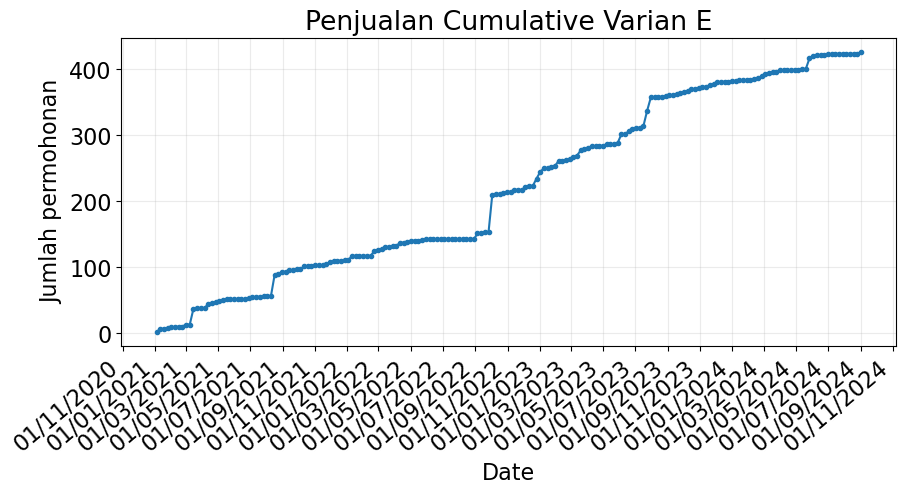

In [10]:
plot_time_series(df_E_weekly["Tgl. Mohon"], df_E_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian E",
                xlabel="Date", ylabel="Jumlah permohonan")

In [73]:
# ADF_result = adfuller(df_E_count["cumulative_sum"])
# print(f"ADF statistic: {ADF_result[0]}")
# print(F"p-value: {ADF_result[1]}")

In [11]:
ADF_result = adfuller(df_E_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.5583566577354289
p-value: 0.8801168541331186


fisrt diff (_d_=1)

In [12]:
E_diff = np.diff(df_E_count["cumulative_sum"], n=1)
ADF_result = adfuller(E_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -10.754267054440884
p-value: 2.6174268094557774e-19


In [76]:
# E_diff = np.diff(df_E_weekly["cumulative_sum"], n=1)
# ADF_result = adfuller(E_diff)
# print(f"ADF statistic: {ADF_result[0]}")
# print(F"p-value: {ADF_result[1]}")

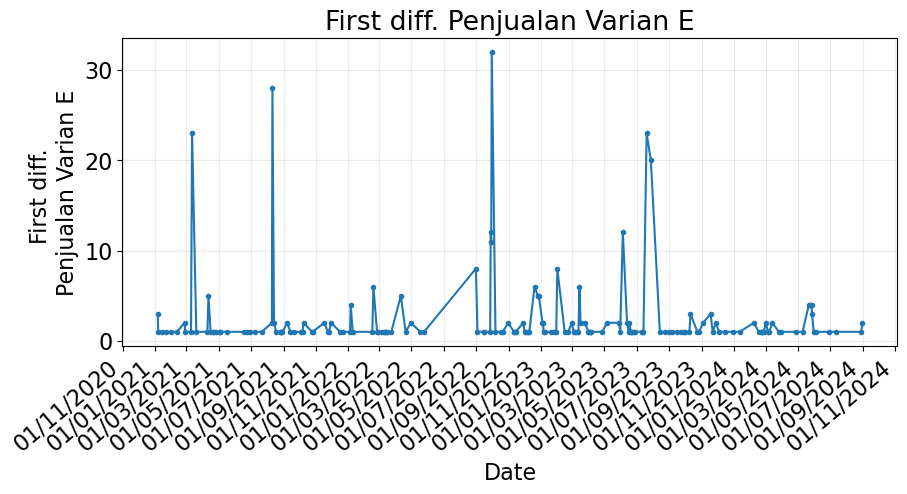

In [13]:
plot_time_series(df_E_count["Tgl. Mohon"].iloc[1:], E_diff, 
                 title="First diff. Penjualan Varian E",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian E")

In [78]:
# plot_time_series(df_E_weekly["Tgl. Mohon"].iloc[1:], E_diff, 
#                  title="First diff. Penjualan Varian E",
#                  xlabel="Date", ylabel="Jumlah Permohonan")

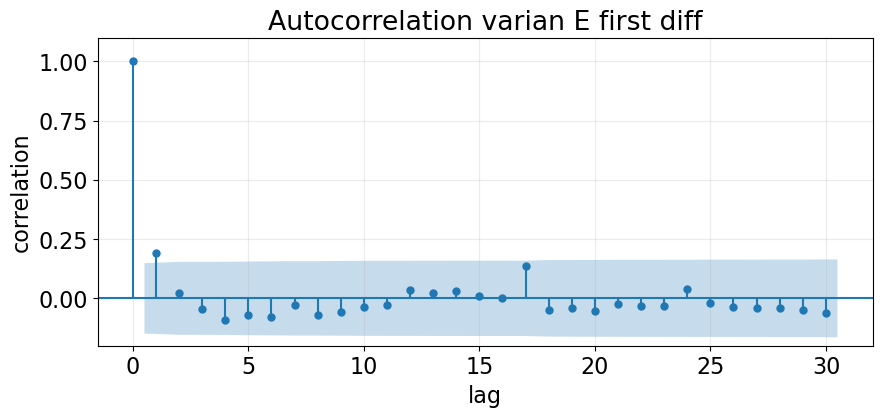

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(E_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian E first diff")
ax.grid("on")

plt.show(fig)

MA(1)

In [80]:
# fig, ax = plt.subplots(figsize=(10, 4))

# fig = plot_acf(E_diff, lags=30, ax=ax)

# ax.set_ylim([-.2, 1.1])
# ax.set_ylabel("correlation")
# ax.set_xlabel("lag")
# ax.set_title("Autocorrelation varian E first diff")
# ax.grid("on")

# plt.show(fig)

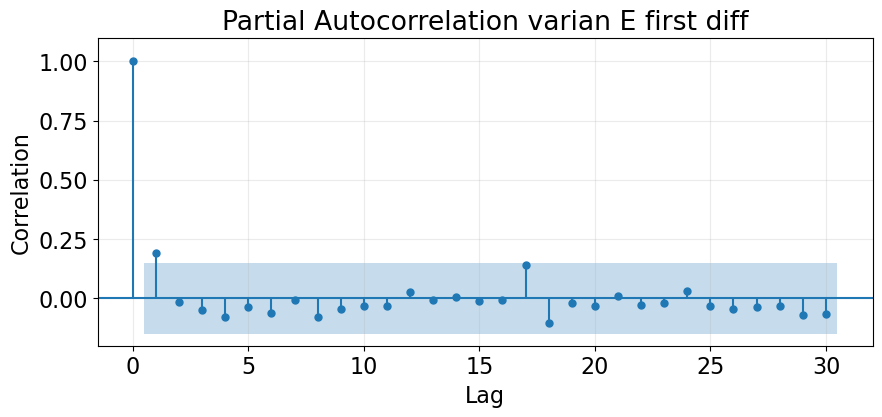

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(E_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian E first diff")
ax.grid("on")

plt.show()

AR(1)

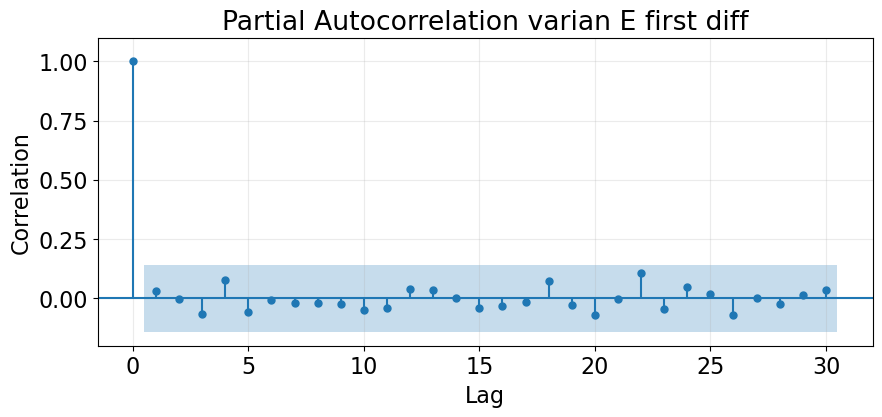

In [62]:
# fig, ax = plt.subplots(figsize=(10, 4))

# plot_pacf(E_diff, lags=30, ax=ax)

# ax.set_ylim([-0.2, 1.1])
# ax.set_ylabel("Correlation")
# ax.set_xlabel("Lag")
# ax.set_title("Partial Autocorrelation varian E first diff")
# ax.grid("on")

# plt.show()

### Data Splitting

In [16]:
df_E_diff = pd.DataFrame({
    "Tgl. Mohon": df_E_count["Tgl. Mohon"].iloc[1:],
    "E_diff": E_diff})

split_idx = int(0.8 * len(df_E_diff))
df_train = df_E_diff.iloc[:split_idx].copy()
df_test = df_E_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (139, 35)


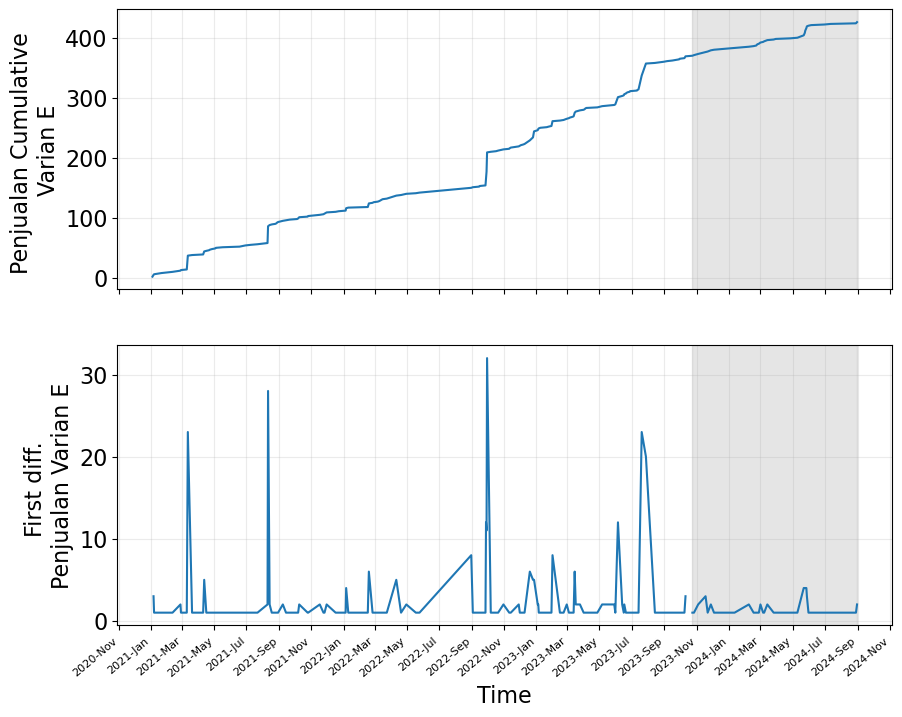

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_E_count["Tgl. Mohon"], df_E_count["cumulative_sum"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan Cumulative \nVarian E")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian E")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### MA

In [18]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["E_diff"])
      pred_mean.extend(mean for _ in range(window))
    # print(len(pred_mean), horizon)
    if len(pred_mean) > horizon:  # cut over counting in (mean for _ in range(window))
      pred_mean = pred_mean[:horizon]

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["E_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    if len(pred_last_value) > horizon:  # cut over counting in (last_value for _ in range(window))
      pred_last_value = pred_last_value[:horizon]

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["E_diff"], order=(0, 1))
      model = SARIMAX(df[:i]["E_diff"], order=(0, 0, 1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    if len(pred_MA) > horizon:  # cut over counting in (.iloc[-window:])
      pred_MA = pred_MA[:horizon]

    return pred_MA

In [19]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 1

pred_mean = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA

pred_df

,Tgl. Mohon,E_diff,pred_mean,pred_last_value,pred_MA
140,2023-10-24,1,2.640288,3,0.820864
141,2023-10-27,1,2.628571,1,0.052996
142,2023-11-04,2,2.617021,1,0.280466
143,2023-11-18,3,2.612676,2,0.509812
144,2023-11-22,1,2.615385,3,0.739855
145,2023-11-28,2,2.604167,1,0.077279
146,2023-12-04,1,2.600000,2,0.571441
147,2023-12-16,1,2.589041,1,0.127342
148,2023-12-30,1,2.578231,1,0.259500
149,2024-01-12,1,2.567568,1,0.220266


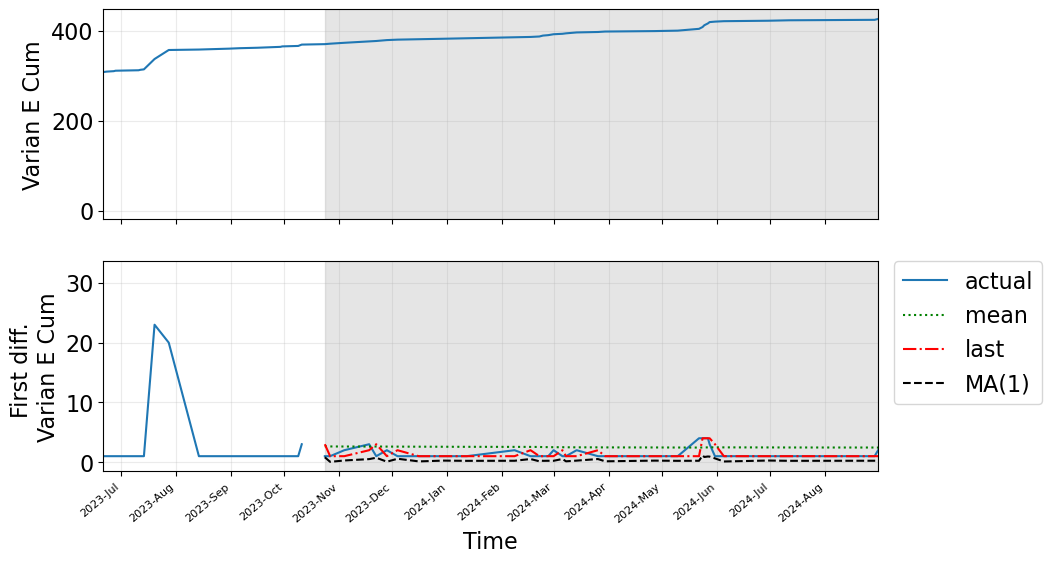

In [20]:
start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian E Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size (8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])

axes[0].grid("on")
axes[0].set_ylabel("Varian E Cum")
axes[0].set_xlim(xlim)


plt.show(fig)

In [21]:
mse_mean = mean_squared_error(pred_df["E_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["E_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["E_diff"], pred_df["pred_MA"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")

MSE mean: 1.8630639834259277
MSE last: 0.9428571428571428
MSE MA: 2.3625068367542865


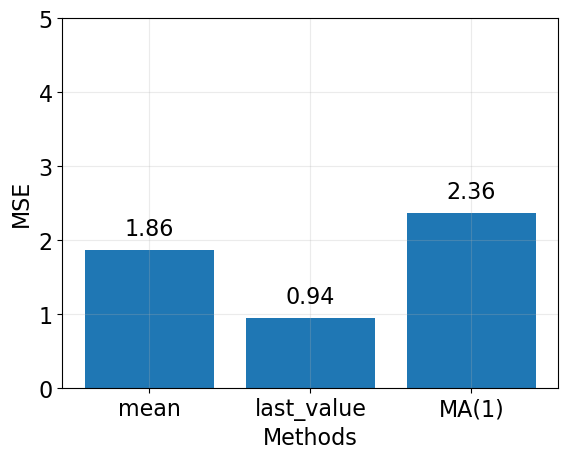

In [22]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)"]
y_array = [mse_mean, mse_last, mse_MA]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [23]:
idx_y0 = len(df_train) + 1 
y0 = df_E_count.iloc[idx_y0]["cumulative_sum"]
# print(y0)
df_test_E = df_E_count[idx_y0:].copy()
df_test_E["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
df_test_E["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
df_test_E["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
df_test_E.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_last_value,pred_MA
140,2023-10-24,1,370,372.640288,373,370.820864
141,2023-10-27,1,371,375.268859,374,370.873860
142,2023-11-04,2,373,377.885880,375,371.154326
143,2023-11-18,3,376,380.498557,377,371.664138
144,2023-11-22,1,377,383.113941,380,372.403994


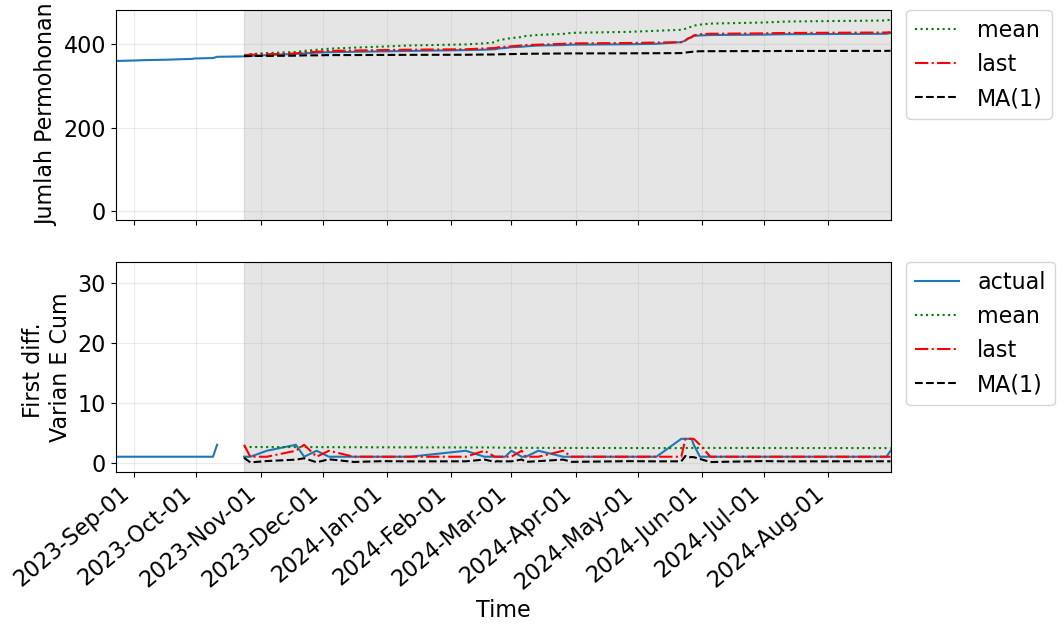

In [24]:
start_idx = 130  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian E Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])

# -- prediction for the original data
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_MA"], "k--", label="MA(1)")

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Permohonan")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)

### Evaluasi MA(1)

MAE

In [25]:
mae_mean_undiff = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_MA"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")

MAE mean: 19.915240327030926
MAE last: 2.3714285714285714
MAE MA: 19.517270201248078


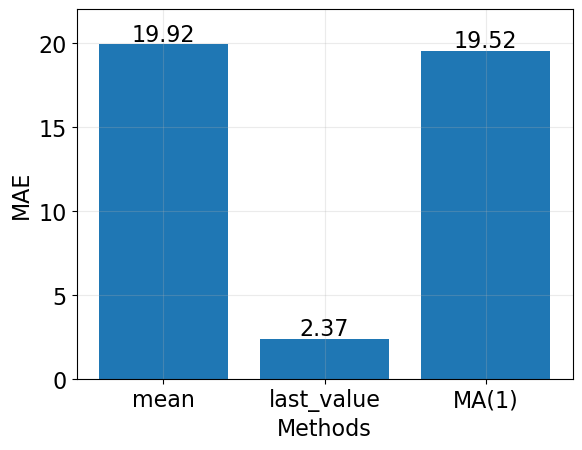

In [26]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 22])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [27]:
mse_mean_undiff = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_mean"])
mse_last_undiff = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_last_value"])
mse_MA_undiff   = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_MA"])

print(f"MSE mean: {mse_mean_undiff}")
print(f"MSE last: {mse_last_undiff}")
print(f"MSE MA: {mse_MA_undiff}")

MSE mean: 482.8439417083725
MSE last: 6.6571428571428575
MSE MA: 548.0888519576326


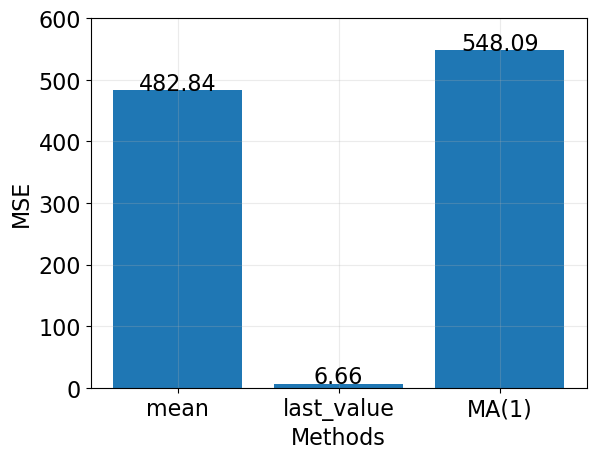

In [28]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)"]
y_array = [mse_mean_undiff, mse_last_undiff, mse_MA_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 600])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [29]:
rmse_mean_undiff = np.sqrt(mse_mean_undiff)
rmse_last_undiff = np.sqrt(mse_last_undiff)
rmse_MA_undiff = np.sqrt(mse_MA_undiff)

print(f"RMSE mean: {rmse_mean_undiff}")
print(f"RMSE last: {rmse_last_undiff}")
print(f"RMSE MA: {rmse_MA_undiff}")

RMSE mean: 21.97371023992927
RMSE last: 2.5801439605461662
RMSE MA: 23.411297528279647


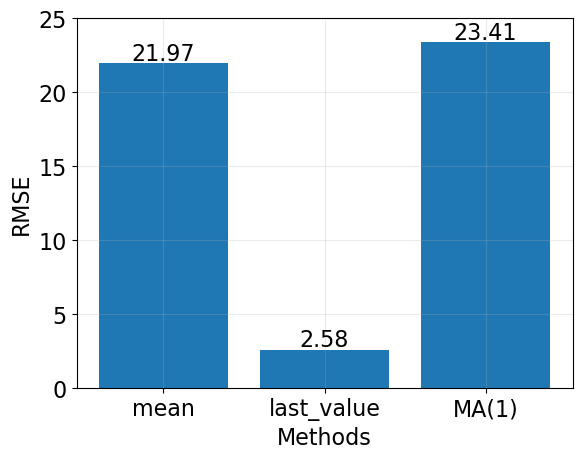

In [30]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)"]
y_array = [rmse_mean_undiff, rmse_last_undiff, rmse_MA_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 25])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [31]:
mape_mean_undiff = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_mean"])
mape_last_undiff = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_last_value"])
mape_MA_undiff   = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_MA"])

print(f"MAPE mean: {mape_mean_undiff}")
print(f"MAPE last: {mape_last_undiff}")
print(f"MAPE MA: {mape_MA_undiff}")

MAPE mean: 0.0495038161462844
MAPE last: 0.006025743945012045
MAPE MA: 0.04799975221438098


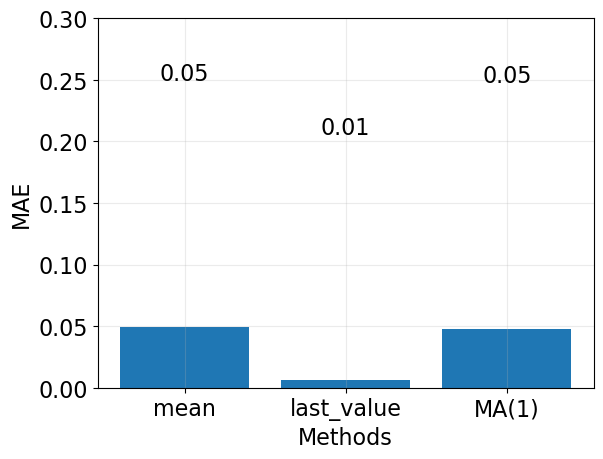

In [32]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)"]
y_array = [mape_mean_undiff, mape_last_undiff, mape_MA_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 0.3])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MASE

In [33]:
naive = np.abs(np.diff(df_test_E["cumulative_sum"])).mean()

mase_mean_undiff = mae_mean_undiff / naive
mase_last_undiff = mae_last_undiff / naive
mase_MA_undiff   = mae_MA_undiff / naive

print(f"MASE mean: {mase_mean_undiff}")
print(f"MASE last: {mase_last_undiff}")
print(f"MASE MA: {mase_MA_undiff}")

MASE mean: 12.091395912840206
MASE last: 1.439795918367347
MASE MA: 11.849771193614904


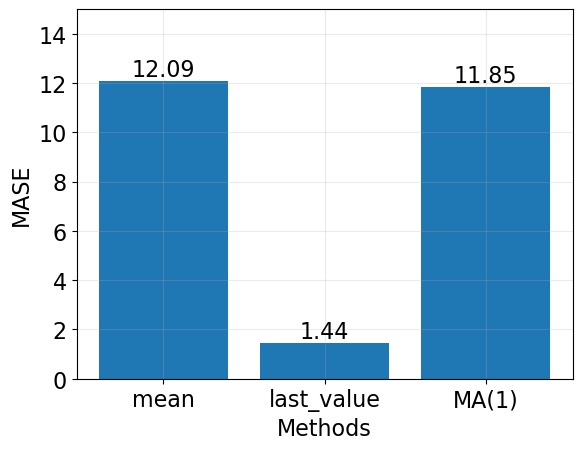

In [34]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)"]
y_array = [mase_mean_undiff, mase_last_undiff, mase_MA_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### ARIMA

In [35]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [36]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 1

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [37]:
result_df = optimize_ARIMA(df_train["E_diff"], order_list, d,
                            enforce_invertibility=True,
                            enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 3)
(3, 0)
(3, 1)
(3, 2)
(3, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",834.593623
1,"(0, 2)",834.675263
2,"(0, 3)",836.531455
3,"(2, 1)",836.556272
4,"(1, 2)",836.568056
5,"(0, 1)",837.631106
6,"(3, 3)",837.978755
7,"(3, 1)",838.235507
8,"(2, 2)",838.357165
9,"(1, 3)",838.535629


In [38]:
best_p, best_q = (1, 1)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (1, 1)


In [39]:
model_arima_best = SARIMAX(df_train["E_diff"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

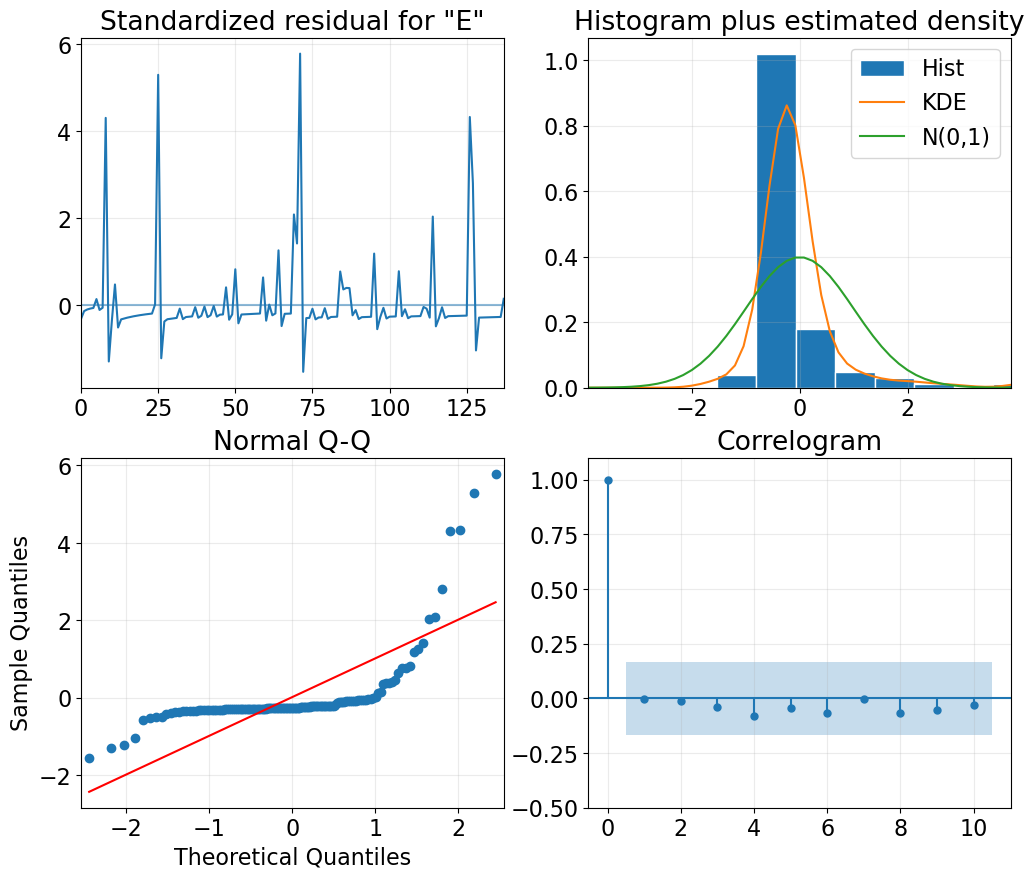

In [40]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [41]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)

pred_mean = np.ones(HORIZON)*np.mean(df_train["E_diff"])
pred_naive_seasonal = df_train["E_diff"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_mean"] = pred_mean
df_test_pred["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred["pred_arima"] = pred_arima

df_test_pred.head()

,Tgl. Mohon,E_diff,pred_mean,pred_naive_seasonal,pred_arima
140,2023-10-24,1,2.640288,6,2.709430
141,2023-10-27,1,2.640288,2,2.654394
142,2023-11-04,2,2.640288,2,2.643969
143,2023-11-18,3,2.640288,1,2.641995
144,2023-11-22,1,2.640288,1,2.641621


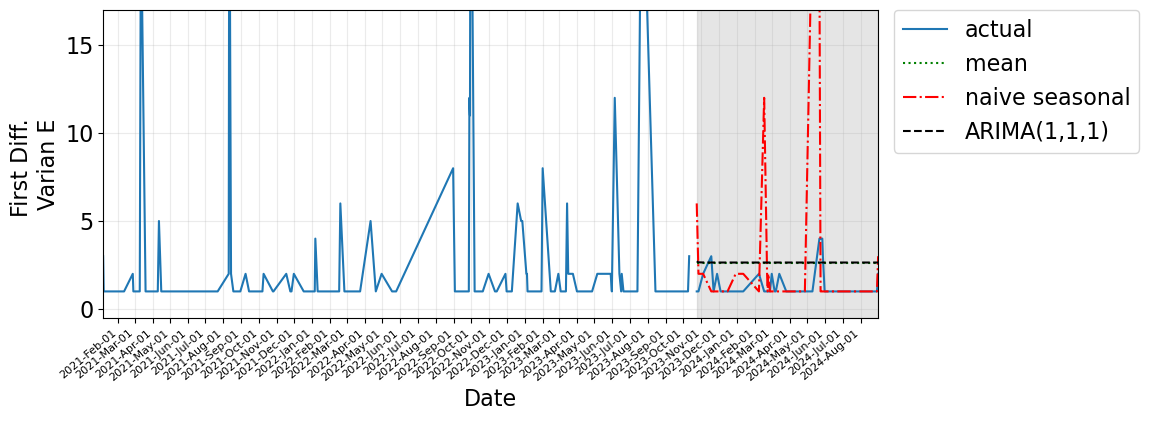

In [42]:
start_idx = 0  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["E_diff"])
ax.plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("First Diff. \nVarian E")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size (8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

In [43]:
idx_y0 = len(df_train) + 1 
y0 = df_E_count.iloc[idx_y0]["cumulative_sum"]
# print(y0)
df_test_E_ARIMA = df_E_count[idx_y0:].copy()
df_test_E_ARIMA["pred_mean"] = y0 + df_test_pred["pred_mean"].cumsum()
df_test_E_ARIMA["pred_naive_seasonal"] = y0 + df_test_pred["pred_naive_seasonal"].cumsum()
df_test_E_ARIMA["pred_arima"] = y0 + df_test_pred["pred_arima"].cumsum()
df_test_E_ARIMA.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_naive_seasonal,pred_arima
140,2023-10-24,1,370,372.640288,376,372.709430
141,2023-10-27,1,371,375.280576,378,375.363824
142,2023-11-04,2,373,377.920863,380,378.007793
143,2023-11-18,3,376,380.561151,381,380.649787
144,2023-11-22,1,377,383.201439,382,383.291408


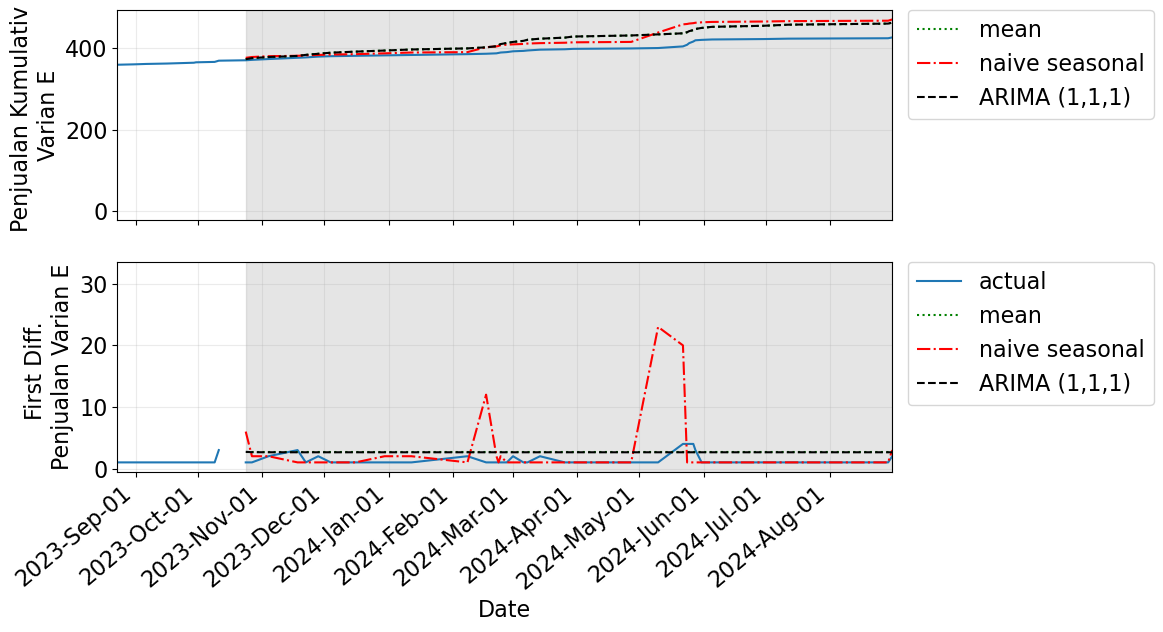

In [44]:
start_idx = 130  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Date")
axes[1].set_ylabel("First Diff. \nPenjualan Varian E")
axes[1].grid("on")

# -- prediction
axes[1].plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_mean"], "g:", label="mean")
axes[1].plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
axes[1].plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA (1,1,1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])

# -- prediction for the original data
axes[0].plot(df_test_E_ARIMA['Tgl. Mohon'], df_test_E_ARIMA["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_E_ARIMA['Tgl. Mohon'], df_test_E_ARIMA["pred_naive_seasonal"], "r-.", label="naive seasonal")
axes[0].plot(df_test_E_ARIMA['Tgl. Mohon'], df_test_E_ARIMA["pred_arima"], "k--", label="ARIMA (1,1,1)")

axes[0].grid("on")
axes[0].set_ylabel("Penjualan Kumulativ \nVarian E")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi ARIMA (1,1,1)

MAE

In [136]:
mae_mean           = mean_absolute_error(df_test_pred["E_diff"], df_test_pred["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred["E_diff"], df_test_pred["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred["E_diff"], df_test_pred["pred_arima"])

print(f"MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"MAE ARIMA: {mae_arima}")

MAE mean: 1.3636176772867419
MAE naive seasonal: 2.2
MAE ARIMA: 1.3668029471507033


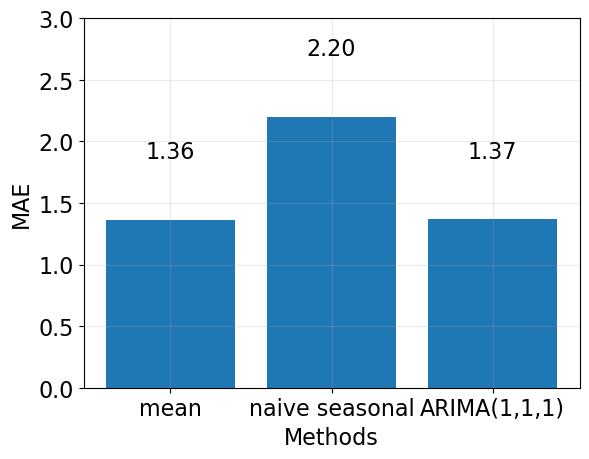

In [137]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 3])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [138]:
mse_mean = mean_squared_error(df_test_pred["E_diff"], df_test_pred["pred_mean"])
mse_naive_seasonal = mean_squared_error(df_test_pred["E_diff"], df_test_pred["pred_naive_seasonal"])
mse_arima = mean_squared_error(df_test_pred["E_diff"], df_test_pred["pred_arima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE ARIMA: {mse_arima}")

MSE mean: 2.0570393428320033
MSE naive seasonal: 26.6
MSE ARIMA: 2.067361749336573


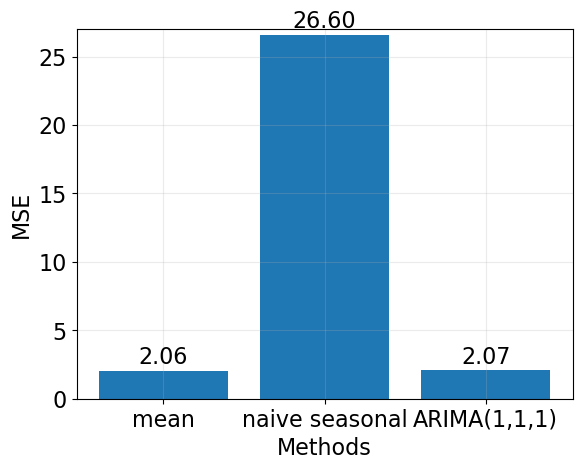

In [139]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mse_mean, mse_naive_seasonal, mse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 27])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [140]:
rmse_mean = np.sqrt(mse_mean)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima = np.sqrt(mse_arima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal}")
print(f"RMSE ARIMA: {rmse_arima}")

RMSE mean: 1.4342382447947772
RMSE naive seasonal: 5.157518783291051
RMSE ARIMA: 1.4378323091851055


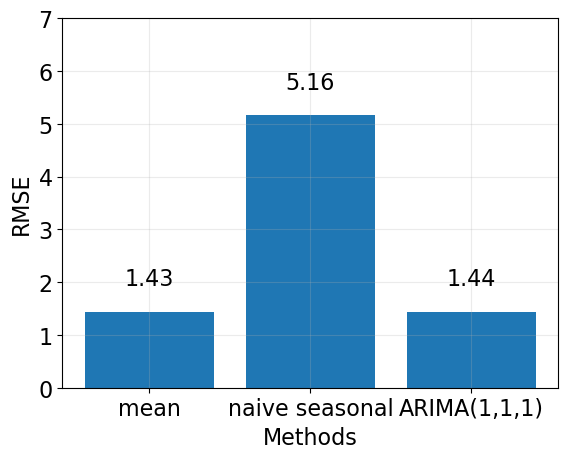

In [141]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [rmse_mean, rmse_naive_seasonal, rmse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 7])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [142]:
mape_mean = np.mean(np.abs((df_test_pred["E_diff"] - df_test_pred["pred_mean"]) / df_test_pred["E_diff"])) * 100
mape_naive_seasonal = np.mean(np.abs((df_test_pred["E_diff"] - df_test_pred["pred_naive_seasonal"]) / df_test_pred["E_diff"])) * 100
mape_arima = np.mean(np.abs((df_test_pred["E_diff"] - df_test_pred["pred_arima"]) / df_test_pred["E_diff"])) * 100

print(f"MAPE mean: {mape_mean:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

MAPE mean: 117.85%
MAPE naive seasonal: 151.67%
MAPE ARIMA: 118.17%


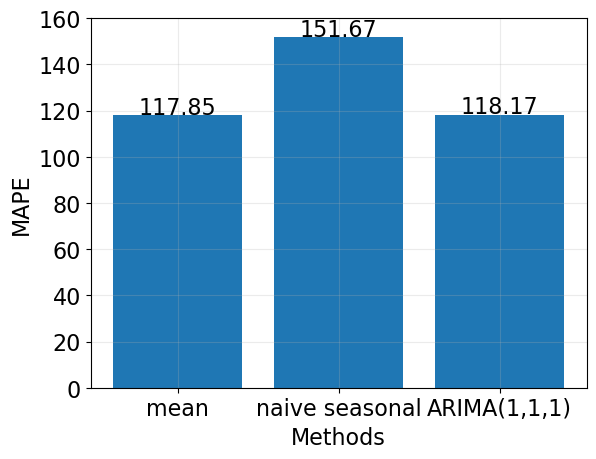

In [143]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 160])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MASE

In [144]:
mase_mean = mae_mean / mae_naive_seasonal
mase_arima = mae_arima / mae_naive_seasonal

print(f"MASE mean: {mase_mean:.2f}")
print(f"MASE ARIMA: {mase_arima:.2f}")

MASE mean: 0.62
MASE ARIMA: 0.62


In [146]:
naive = np.abs(np.diff(df_test_pred["E_diff"])).mean()

mase_mean = mae_mean_undiff / naive
mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima = mae_arima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE ARIMA: {mase_arima}")

MASE mean: 35.63779847995008
MASE naive seasonal: 3.936842105263158
MASE ARIMA: 2.4458579054275744


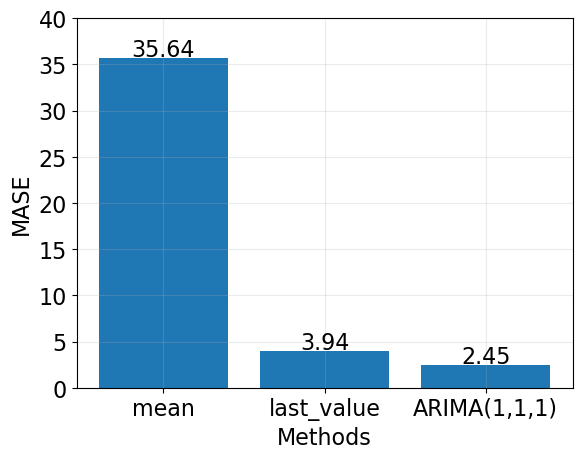

In [149]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mase_mean, mase_naive_seasonal, mase_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 40])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Evaluasi ARIMA undiff

MAE

In [57]:
mae_mean_undiff_ARIMA           = mean_absolute_error(df_test_E_ARIMA["cumulative_sum"], df_test_E_ARIMA["pred_mean"])
mae_naive_seasonal_undiff_ARIMA = mean_absolute_error(df_test_E_ARIMA["cumulative_sum"], df_test_E_ARIMA["pred_naive_seasonal"])
mae_arima_undiff          = mean_absolute_error(df_test_E_ARIMA["cumulative_sum"], df_test_E_ARIMA["pred_arima"])

print(f"MAE mean: {mae_mean_undiff_ARIMA}")
print(f"MAE naive seasonal: {mae_naive_seasonal_undiff_ARIMA}")
print(f"MAE ARIMA: {mae_arima_undiff}")

MAE mean: 21.49660842754367
MAE naive seasonal: 22.771428571428572
MAE ARIMA: 21.60222925434706


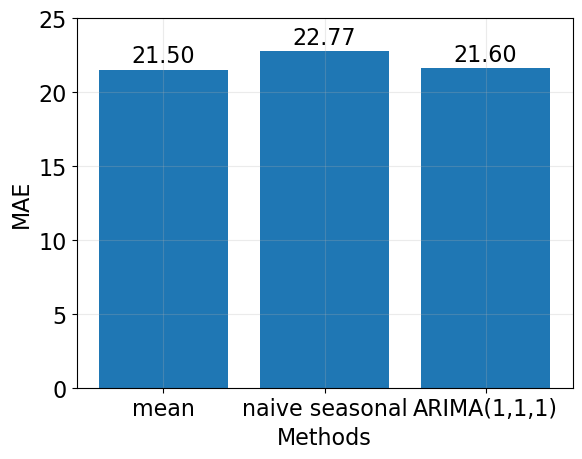

In [58]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mae_mean_undiff_ARIMA, mae_naive_seasonal_undiff_ARIMA, mae_arima_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 25])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [59]:
mse_mean_undiff_ARIMA           = mean_squared_error(df_test_E_ARIMA["cumulative_sum"], df_test_E_ARIMA["pred_mean"])
mse_naive_seasonal_undiff_ARIMA = mean_squared_error(df_test_E_ARIMA["cumulative_sum"], df_test_E_ARIMA["pred_naive_seasonal"])
mse_arima_undiff                = mean_squared_error(df_test_E_ARIMA["cumulative_sum"], df_test_E_ARIMA["pred_arima"])

print(f"MSE mean: {mse_mean_undiff_ARIMA}")
print(f"MSE naive seasonal: {mse_naive_seasonal_undiff_ARIMA}")
print(f"MSE ARIMA: {mse_arima_undiff}")

MSE mean: 572.1365812180671
MSE naive seasonal: 800.3142857142857
MSE ARIMA: 576.9632497547304


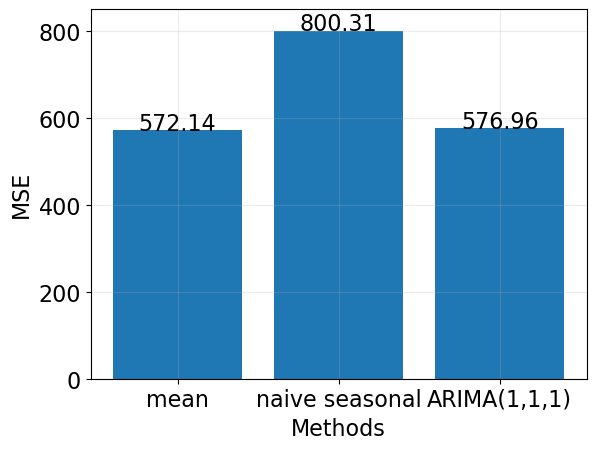

In [60]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mse_mean_undiff_ARIMA, mse_naive_seasonal_undiff_ARIMA, mse_arima_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 850])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [62]:
rmse_mean_undiff_ARIMA = np.sqrt(mse_mean_undiff_ARIMA)
rmse_naive_seasonal_undiff_ARIMA = np.sqrt(mse_naive_seasonal_undiff_ARIMA)
rmse_arima_undiff = np.sqrt(mse_arima_undiff)

print(f"RMSE mean: {rmse_mean_undiff_ARIMA}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal_undiff_ARIMA}")
print(f"RMSE ARIMA: {rmse_arima_undiff}")

RMSE mean: 23.919376689580922
RMSE naive seasonal: 28.289826540901338
RMSE ARIMA: 24.020059320383254


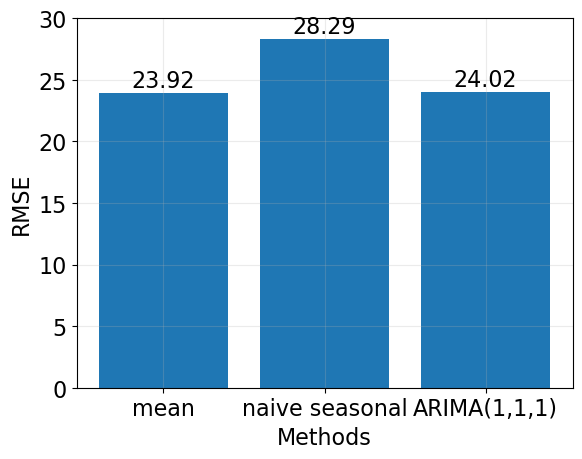

In [64]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [rmse_mean_undiff_ARIMA, rmse_naive_seasonal_undiff_ARIMA, rmse_arima_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 30])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [65]:
mape_mean_undiff_ARIMA = np.mean(np.abs((df_test_E_ARIMA["cumulative_sum"] - df_test_E_ARIMA["pred_mean"]) / df_test_E_ARIMA["cumulative_sum"])) * 100
mape_naive_seasonal_undiff_ARIMA = np.mean(np.abs((df_test_E_ARIMA["cumulative_sum"] - df_test_E_ARIMA["pred_naive_seasonal"]) / df_test_E_ARIMA["cumulative_sum"])) * 100
mape_arima_undiff = np.mean(np.abs((df_test_E_ARIMA["cumulative_sum"] - df_test_E_ARIMA["pred_arima"]) / df_test_E_ARIMA["cumulative_sum"])) * 100

print(f"MAPE mean: {mape_mean_undiff_ARIMA:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal_undiff_ARIMA:.2f}%")
print(f"MAPE ARIMA: {mape_arima_undiff:.2f}%")

MAPE mean: 5.34%
MAPE naive seasonal: 5.60%
MAPE ARIMA: 5.36%


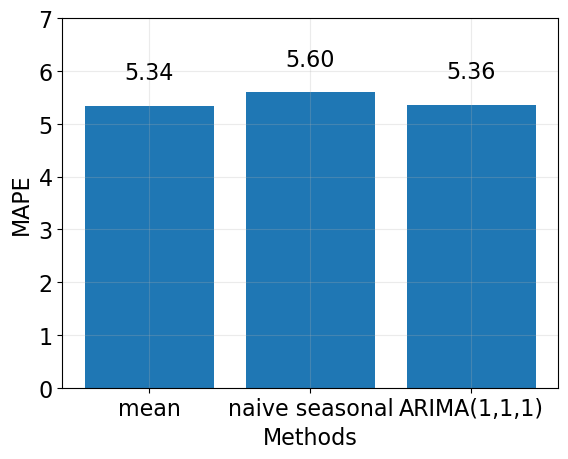

In [68]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean_undiff_ARIMA, mape_naive_seasonal_undiff_ARIMA, mape_arima_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 7])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MASE

In [70]:
naive_undiff_ARIMA = np.abs(np.diff(df_test_E_ARIMA["cumulative_sum"])).mean()

mase_mean_undiff_ARIMA           = mae_mean_undiff / naive_undiff_ARIMA
mase_naive_seasonal_undiff_ARIMA = mae_naive_seasonal_undiff_ARIMA / naive_undiff_ARIMA
mase_arima_undiff                = mae_arima_undiff / naive_undiff_ARIMA

print(f"MASE mean: {mase_mean_undiff_ARIMA}")
print(f"MASE naive seasonal: {mase_naive_seasonal_undiff_ARIMA}")
print(f"MASE ARIMA: {mase_arima_undiff}")

MASE mean: 12.091395912840206
MASE naive seasonal: 13.825510204081635
MASE ARIMA: 13.115639190139285


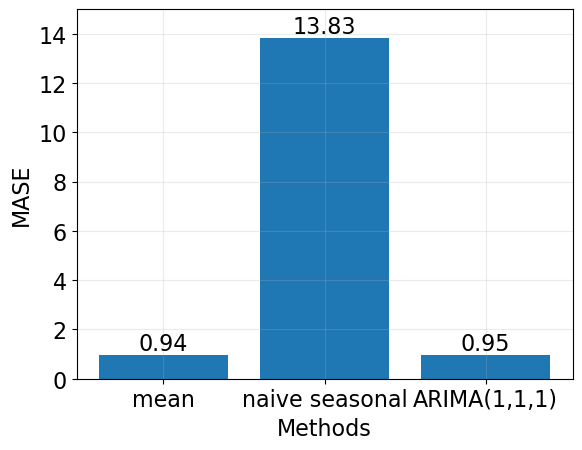

In [72]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mase_mean_undiff_ARIMA, mase_naive_seasonal_undiff_ARIMA, mase_arima_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### ARMA

In [86]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

  result = []

  for order in notebook.tqdm(order_list):
    try:
      model = SARIMAX(endog, order=(order[0], 0, order[1]), 
                      simple_differencing=False).fit(disp=False)
    except:
      continue 

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [87]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [88]:
result_df = optimize_ARMA(df_train["E_diff"], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:

,"(p,q)",AIC
0,"(2, 1)",841.374816
1,"(1, 2)",841.456694
2,"(1, 3)",843.314721
3,"(3, 1)",843.339822
4,"(2, 2)",843.351966
5,"(1, 1)",844.406506
6,"(3, 2)",845.371907
7,"(2, 3)",845.405642
8,"(3, 3)",850.211319
9,"(1, 0)",853.678570


In [89]:
model_arma_2_1 = SARIMAX(df_train["E_diff"], order=(2, 0, 1), 
                        simple_differencing=False)
model_arma_2_1_fit = model_arma_2_1.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


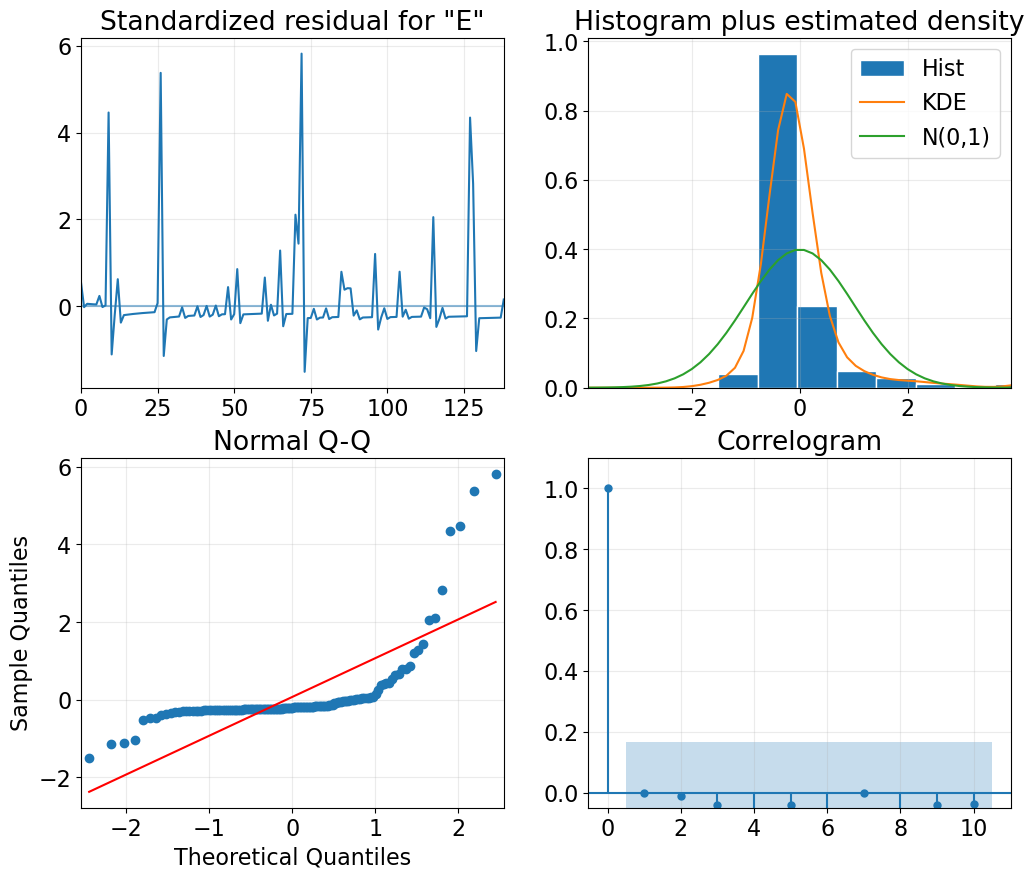

In [90]:
fig = model_arma_2_1_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.05, 1.1])
plt.show(fig)

In [91]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str, df_column_name: str, arma_order: tuple = None) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i][df_column_name])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i][df_column_name].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  elif method == "ARMA":
    pred_ARMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i][df_column_name], order=arma_order)
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_ARMA.extend(oos_pred)

    return pred_ARMA

In [92]:
df_test_pred_ARMA = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 1      # from the order of q in ARMA(2,1)

pred_mean = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, 
                              "mean", "E_diff")
pred_last_value = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, 
                                    "last", "E_diff")
pred_arma = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, 
                              "ARMA", "E_diff", arma_order=(2, 0, 1))

df_test_pred_ARMA["pred_mean"] = pred_mean
df_test_pred_ARMA["pred_last_value"] = pred_last_value
df_test_pred_ARMA["pred_arma"] = pred_arma

df_test_pred_ARMA.head()

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: M

,Tgl. Mohon,E_diff,pred_mean,pred_last_value,pred_arma
140,2023-10-24,1,2.640288,3,2.632376
141,2023-10-27,1,2.628571,1,2.242254
142,2023-11-04,2,2.617021,1,2.231064
143,2023-11-18,3,2.612676,2,2.420723
144,2023-11-22,1,2.615385,3,2.615869


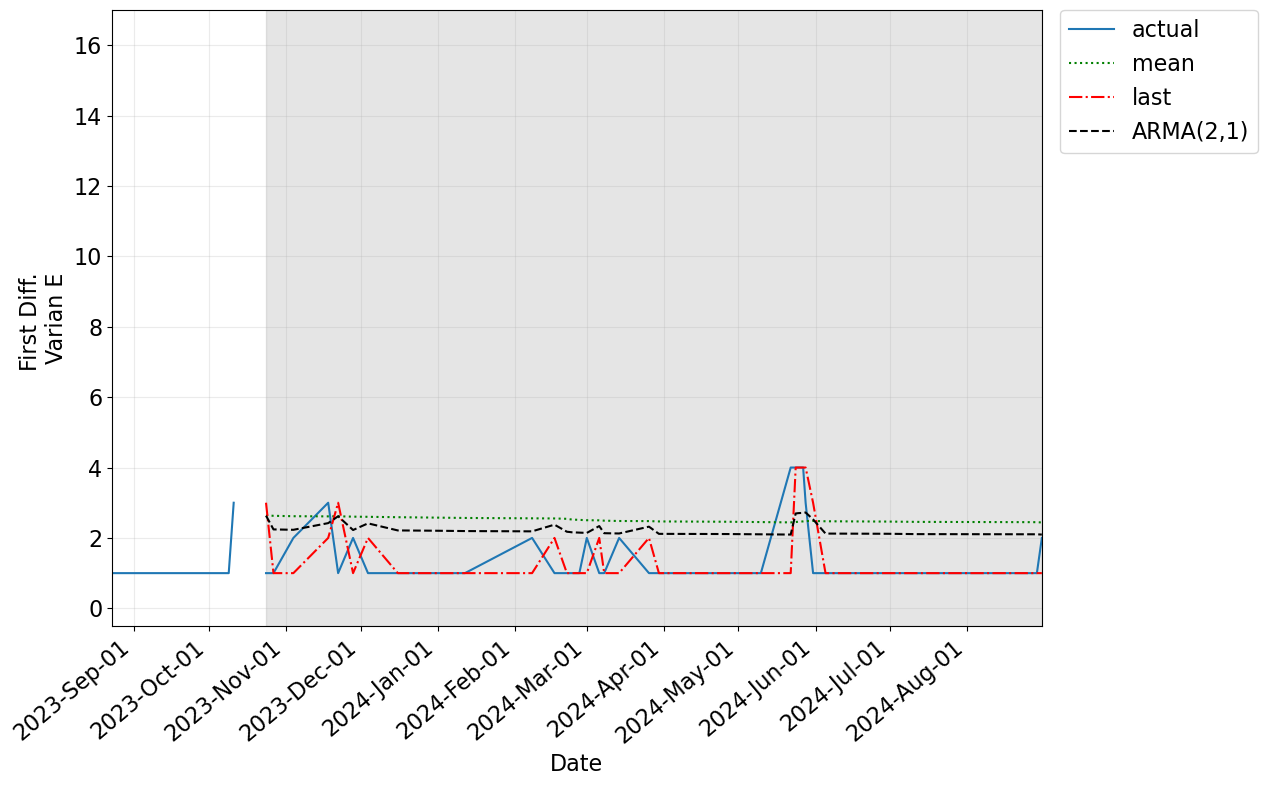

In [115]:
start_idx = 130  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_train["Tgl. Mohon"], df_train["E_diff"])
ax.plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("First Diff. \nVarian E")


ax.grid("on")
# -- prediction
ax.plot(df_test_pred_ARMA["Tgl. Mohon"], df_test_pred_ARMA["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_ARMA["Tgl. Mohon"], df_test_pred_ARMA["pred_last_value"], "r-.", label="last")
ax.plot(df_test_pred_ARMA["Tgl. Mohon"], df_test_pred_ARMA["pred_arma"], "k--", label="ARMA(2,1)")

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  # label.set_size (8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

In [99]:
mse_mean = mean_squared_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_mean"])
mse_last = mean_squared_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_last_value"])
mse_arma = mean_squared_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_arma"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE ARMA: {mse_arma}")

MSE mean: 1.8630639834259277
MSE last: 0.9428571428571428
MSE ARMA: 1.3016212007929109


In [106]:
idx_y0 = len(df_train) + 1 
y0 = df_E_count.iloc[idx_y0]["cumulative_sum"]
# print(y0)
df_test_E_ARMA = df_E_count[idx_y0:].copy()
df_test_E_ARMA["pred_mean"] = y0 + df_test_pred["pred_mean"].cumsum()
df_test_E_ARMA["pred_last_value"] = y0 + df_test_pred["pred_last_value"].cumsum()
df_test_E_ARMA["pred_arma"] = y0 + df_test_pred["pred_arma"].cumsum()
df_test_E_ARMA.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_last_value,pred_arma
140,2023-10-24,1,370,372.640288,373,372.632376
141,2023-10-27,1,371,375.268859,374,374.874630
142,2023-11-04,2,373,377.885880,375,377.105694
143,2023-11-18,3,376,380.498557,377,379.526418
144,2023-11-22,1,377,383.113941,380,382.142287


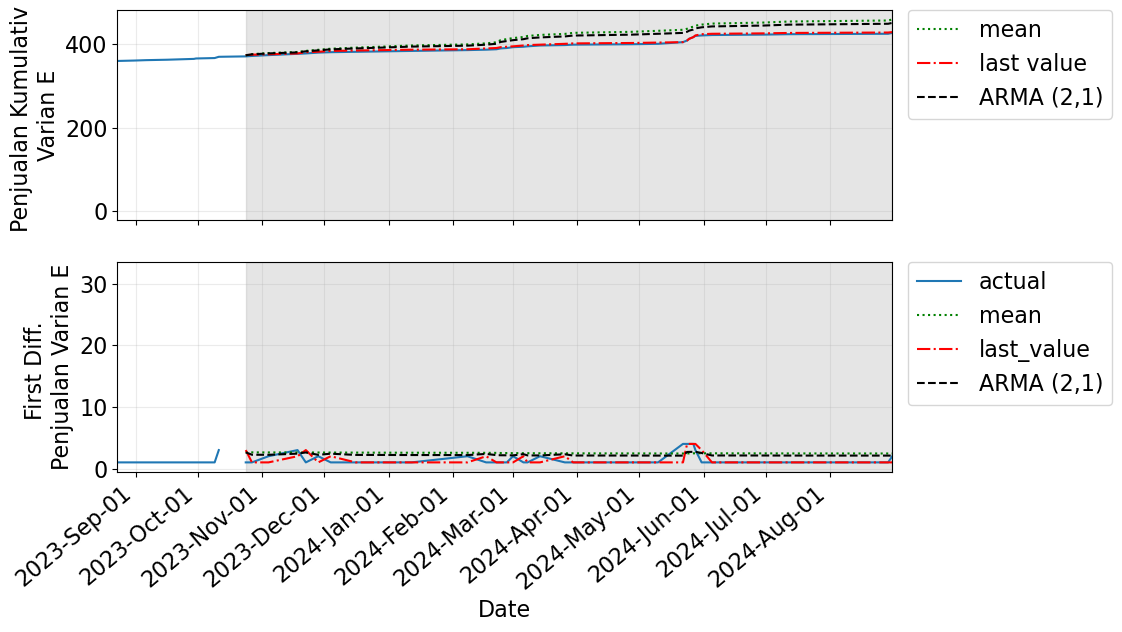

In [114]:
start_idx = 130  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Date")
axes[1].set_ylabel("First Diff. \nPenjualan Varian E")
axes[1].grid("on")

# -- prediction
axes[1].plot(df_test_pred_ARMA["Tgl. Mohon"], df_test_pred_ARMA["pred_mean"], "g:", label="mean")
axes[1].plot(df_test_pred_ARMA["Tgl. Mohon"], df_test_pred_ARMA["pred_last_value"], "r-.", label="last_value")
axes[1].plot(df_test_pred_ARMA["Tgl. Mohon"], df_test_pred_ARMA["pred_arma"], "k--", label="ARMA (2,1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  # label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])

# -- prediction for the original data
axes[0].plot(df_test_E_ARMA['Tgl. Mohon'], df_test_E_ARMA["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_E_ARMA['Tgl. Mohon'], df_test_E_ARMA["pred_last_value"], "r-.", label="last value")
axes[0].plot(df_test_E_ARMA['Tgl. Mohon'], df_test_E_ARMA["pred_arma"], "k--", label="ARMA (2,1)")

axes[0].grid("on")
axes[0].set_ylabel("Penjualan Kumulativ \nVarian E")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi ARMA (2,1)

MAE

In [123]:
mae_mean_arma       = mean_absolute_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_mean"])
mae_last_value_arma = mean_absolute_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_last_value"])
mae_arma            = mean_absolute_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_arma"])

print(f"MAE mean: {mae_mean_arma}")
print(f"MAE last value: {mae_last_value_arma}")
print(f"MAE ARIMA: {mae_arma}")

MAE mean: 1.2954949743808029
MAE last value: 0.6
MAE ARIMA: 1.0374467108930423


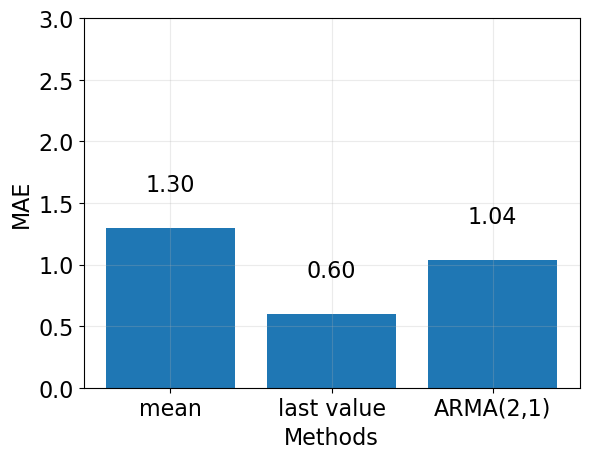

In [129]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [mae_mean_arma, mae_last_value_arma, mae_arma]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 3])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.3, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [125]:
mse_mean_arma       = mean_squared_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_mean"])
mse_last_value_arma = mean_squared_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_last_value"])
mse_arma            = mean_squared_error(df_test_pred_ARMA["E_diff"], df_test_pred_ARMA["pred_arma"])

print(f"MSE mean: {mse_mean_arma}")
print(f"MSE last: {mse_last_value_arma}")
print(f"MSE ARMA: {mse_arma}")

MSE mean: 1.8630639834259277
MSE last: 0.9428571428571428
MSE ARMA: 1.3016212007929109


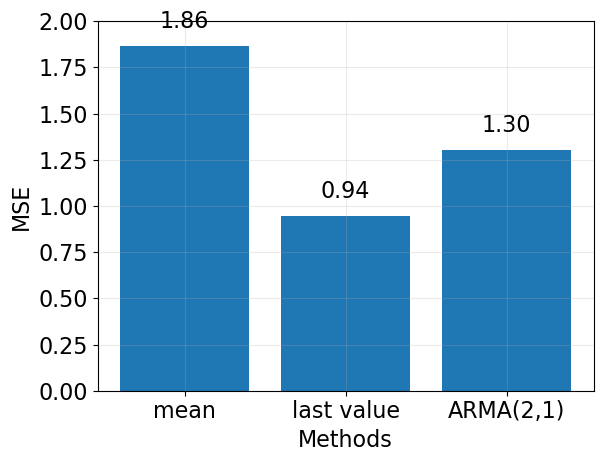

In [128]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [mse_mean_arma, mse_last_value_arma, mse_arma]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 2])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [132]:
rmse_mean_arma       = np.sqrt(mse_mean_arma)
rmse_last_value_arma = np.sqrt(mse_last_value_arma)
rmse_arma            = np.sqrt(mse_arma)

print(f"RMSE mean: {rmse_mean_arma}")
print(f"RMSE naive seasonal: {rmse_last_value_arma}")
print(f"RMSE ARIMA: {rmse_arma}")

RMSE mean: 1.364941018295636
RMSE naive seasonal: 0.9710083124552245
RMSE ARIMA: 1.1408861471649618


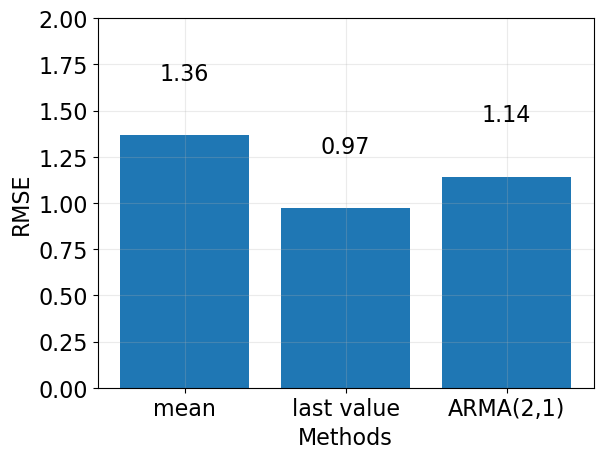

In [133]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [rmse_mean_arma, rmse_last_value_arma, rmse_arma]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 2])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.3, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [135]:
mape_mean_arma       = np.mean(np.abs((df_test_pred_ARMA["E_diff"] - df_test_pred_ARMA["pred_mean"]) / df_test_pred_ARMA["E_diff"])) * 100
mape_last_value_arma = np.mean(np.abs((df_test_pred_ARMA["E_diff"] - df_test_pred_ARMA["pred_last_value"]) / df_test_pred_ARMA["E_diff"])) * 100
mape_arma            = np.mean(np.abs((df_test_pred_ARMA["E_diff"] - df_test_pred_ARMA["pred_arma"]) / df_test_pred_ARMA["E_diff"])) * 100

print(f"MAPE mean: {mape_mean_arma:.2f}%")
print(f"MAPE naive seasonal: {mape_last_value_arma:.2f}%")
print(f"MAPE ARIMA: {mape_arma:.2f}%")

MAPE mean: 110.01%
MAPE naive seasonal: 41.19%
MAPE ARIMA: 88.26%


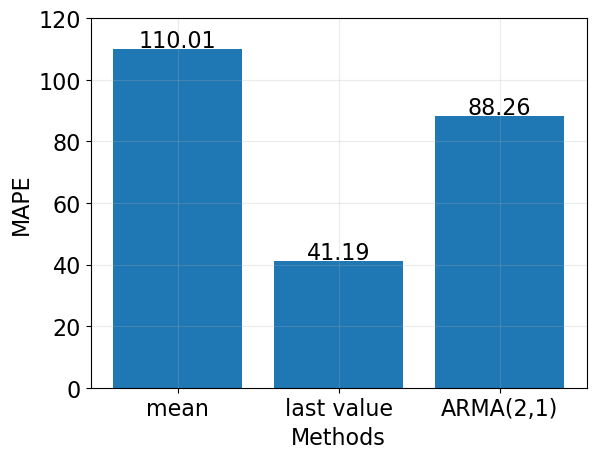

In [137]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [mape_mean_arma, mape_last_value_arma, mape_arma]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 120])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MASE

In [138]:
naive_arma = np.abs(np.diff(df_test_pred["E_diff"])).mean()

mase_mean_arma = mae_mean_arma / naive_arma
mase_last_value_arma = mae_last_value_arma / naive_arma
mase_arma = mae_arma / naive_arma

print(f"MASE mean: {mase_mean_arma}")
print(f"MASE last value: {mase_last_value_arma}")
print(f"MASE ARMA: {mase_arma}")

MASE mean: 2.3182541646814365
MASE last value: 1.0736842105263158
MASE ARMA: 1.856483587913865


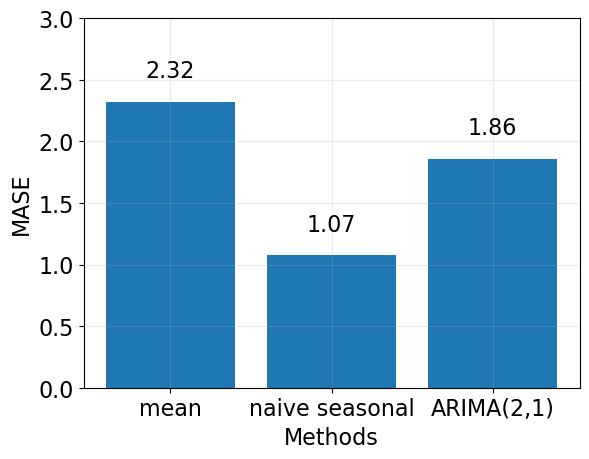

In [160]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1)"]
y_array = [mase_mean_arma, mase_last_value_arma, mase_arma]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 3])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Evaluasi ARMA undiff

MAE

In [143]:
mae_mean_undiff_ARMA       = mean_absolute_error(df_test_E_ARMA["cumulative_sum"], df_test_E_ARMA["pred_mean"])
mae_last_value_undiff_ARMA = mean_absolute_error(df_test_E_ARMA["cumulative_sum"], df_test_E_ARMA["pred_last_value"])
mae_arma_undiff            = mean_absolute_error(df_test_E_ARMA["cumulative_sum"], df_test_E_ARMA["pred_arma"])

print(f"MAE mean: {mae_mean_undiff_ARMA}")
print(f"MAE last value: {mae_last_value_undiff_ARMA}")
print(f"MAE ARIMA: {mae_arma_undiff}")

MAE mean: 19.915240327030926
MAE last value: 2.3714285714285714
MAE ARIMA: 15.283674049018224


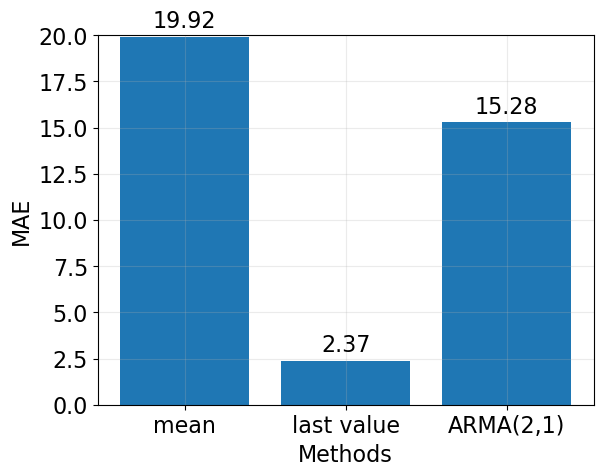

In [144]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [mae_mean_undiff_ARMA, mae_last_value_undiff_ARMA, mae_arma_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [145]:
mse_mean_undiff_ARMA       = mean_squared_error(df_test_E_ARMA["cumulative_sum"], df_test_E_ARMA["pred_mean"])
mse_last_value_undiff_ARMA = mean_squared_error(df_test_E_ARMA["cumulative_sum"], df_test_E_ARMA["pred_last_value"])
mse_arma_undiff            = mean_squared_error(df_test_E_ARMA["cumulative_sum"], df_test_E_ARMA["pred_arma"])

print(f"MSE mean: {mse_mean_undiff_ARMA}")
print(f"MSE last value: {mse_last_value_undiff_ARMA}")
print(f"MSE ARMA: {mse_arma_undiff}")

MSE mean: 482.8439417083725
MSE last value: 6.6571428571428575
MSE ARMA: 280.2662789696926


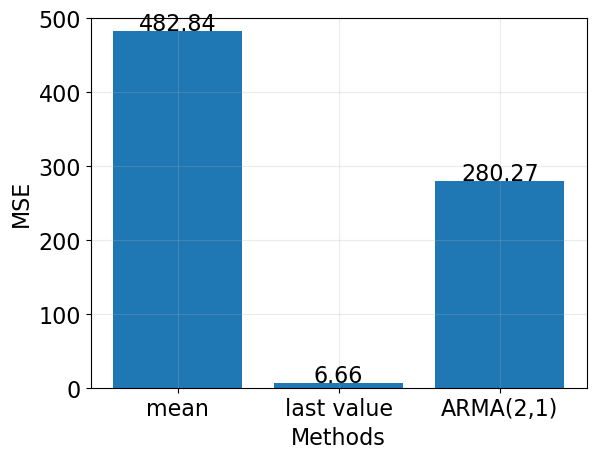

In [147]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [mse_mean_undiff_ARMA, mse_last_value_undiff_ARMA, mse_arma_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 500])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [149]:
rmse_mean_undiff_ARMA       = np.sqrt(mse_mean_undiff_ARMA)
rmse_last_value_undiff_ARMA = np.sqrt(mse_last_value_undiff_ARMA)
rmse_arma_undiff            = np.sqrt(mse_arma_undiff)

print(f"RMSE mean: {rmse_mean_undiff_ARMA}")
print(f"RMSE last value: {rmse_last_value_undiff_ARMA}")
print(f"RMSE ARMA: {rmse_arma_undiff}")

RMSE mean: 21.97371023992927
RMSE last value: 2.5801439605461662
RMSE ARMA: 16.74115524597071


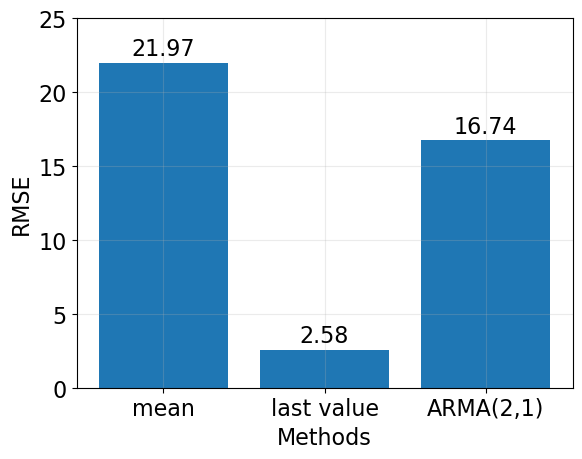

In [151]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [rmse_mean_undiff_ARMA, rmse_last_value_undiff_ARMA, rmse_arma_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 25])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [153]:
mape_mean_undiff_ARMA       = np.mean(np.abs((df_test_E_ARMA["cumulative_sum"] - df_test_E_ARMA["pred_mean"]) / df_test_E_ARMA["cumulative_sum"])) * 100
mape_last_value_undiff_ARMA = np.mean(np.abs((df_test_E_ARMA["cumulative_sum"] - df_test_E_ARMA["pred_last_value"]) / df_test_E_ARMA["cumulative_sum"])) * 100
mape_arma_undiff            = np.mean(np.abs((df_test_E_ARMA["cumulative_sum"] - df_test_E_ARMA["pred_arma"]) / df_test_E_ARMA["cumulative_sum"])) * 100

print(f"MAPE mean: {mape_mean_undiff_ARMA:.2f}%")
print(f"MAPE last value: {mape_last_value_undiff_ARMA:.2f}%")
print(f"MAPE ARMA: {mape_arma_undiff:.2f}%")

MAPE mean: 4.95%
MAPE last value: 0.60%
MAPE ARMA: 3.80%


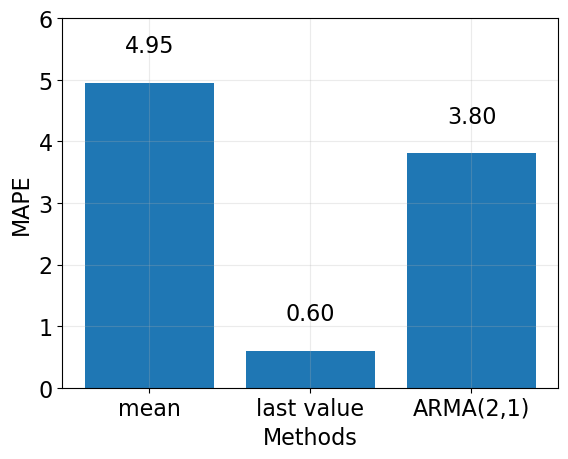

In [155]:
fig, ax = plt.subplots()

x_array = ["mean", "last value", "ARMA(2,1)"]
y_array = [mape_mean_undiff_ARMA, mape_last_value_undiff_ARMA, mape_arma_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 6])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MASE

In [157]:
naive_undiff_ARMA = np.abs(np.diff(df_test_E_ARIMA["cumulative_sum"])).mean()

mase_mean_undiff_ARMA       = mae_mean_undiff_ARMA / naive_undiff_ARMA
mase_last_value_undiff_ARMA = mae_last_value_undiff_ARMA / naive_undiff_ARMA
mase_arma_undiff            = mae_arma_undiff / naive_undiff_ARMA

print(f"MASE mean: {mase_mean_undiff_ARMA}")
print(f"MASE last value: {mase_last_value_undiff_ARMA}")
print(f"MASE ARIMA: {mase_arma_undiff}")

MASE mean: 12.091395912840206
MASE last value: 1.439795918367347
MASE ARIMA: 9.279373529761065


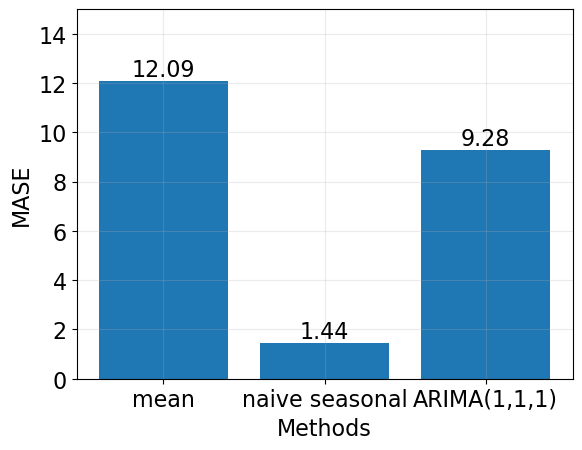

In [159]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mase_mean_undiff_ARMA, mase_last_value_undiff_ARMA, mase_arma_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)